In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
events_df = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip")
events_df

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [4]:
events_df["date"] = pd.to_datetime(events_df.timestamp, unit="s")
events_df["day"] = events_df.date.dt.date
events_df.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<Axes: xlabel='day'>

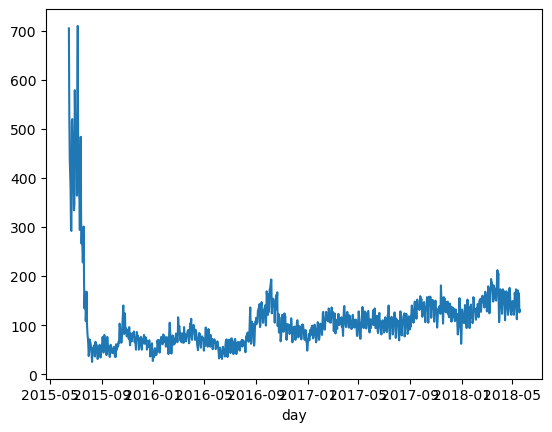

In [5]:
events_df.groupby("day").user_id.nunique().plot()

<Axes: >

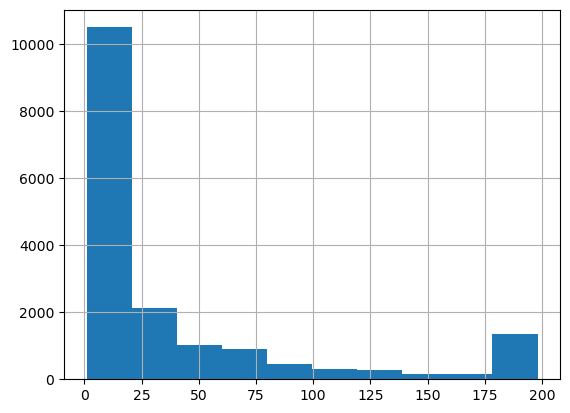

In [6]:
events_df[events_df.action == "passed"].groupby("user_id", as_index=False).agg({"step_id": "count"}).rename(
    columns={"step_id": "passed_steps"}
).passed_steps.hist()

In [7]:
# При таком подходе мы теряем пользователей, у которых нет ни одного пройденного степа (нет "passed")
# Чтобы учесть такие кейсы, можно воспользоваться pivot_table

<Axes: >

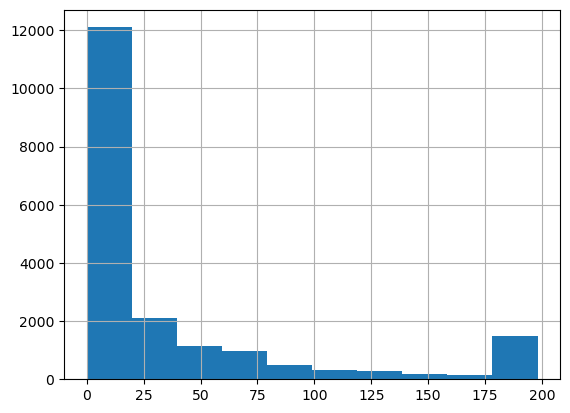

In [8]:
events_df.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0,
).reset_index().discovered.hist()

In [9]:
submissions_df = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip")
submissions_df

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [10]:
submissions_df["date"] = pd.to_datetime(submissions_df.timestamp, unit="s")
submissions_df["day"] = submissions_df.date.dt.date

In [11]:
submissions_df

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [12]:
users_scores = submissions_df.pivot_table(
    index="user_id",
    columns="submission_status",
    values="step_id",
    aggfunc="count",
    fill_value=0,
).reset_index()

In [13]:
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [14]:
gap_data = (
    events_df[["user_id", "day", "timestamp"]]
    .drop_duplicates(subset=["user_id", "day"])
    .groupby("user_id")["timestamp"]
    .apply(list)
    .apply(np.diff)
    .values
)

In [15]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [16]:
gap_data = gap_data / (24 * 60 * 60)

<Axes: >

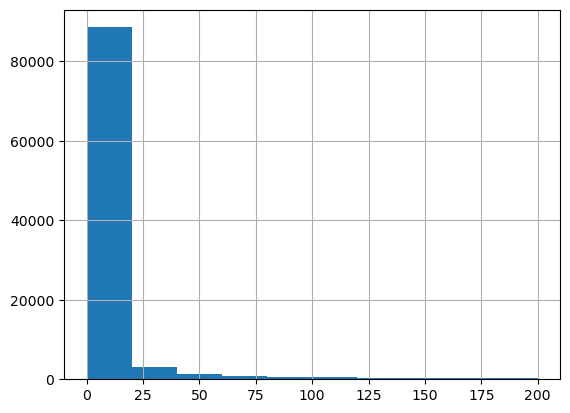

In [17]:
# Гистограмма количества дней перерыва между уроками у пользователей
gap_data[gap_data < 200].hist()

In [18]:
# Максимальное количество дней перерыва между уроками у 90% пользователей
gap_data.quantile(0.90)

18.325995370370403

In [19]:
# Максимальное количество дней перерыва между уроками у 95% пользователей
gap_data.quantile(0.95)

59.760440972222156

In [20]:
# В качестве значения, определяющего количество дней перерыва между уроками,
# после которого можно считать, что пользователь покинул курс
# выберем значение примерно промежуточное межу 90 и 95 процентилями - 30 дней
MAX_GAP_DAYS = 30
MAX_GAP = MAX_GAP_DAYS * 24 * 60 * 60
MAX_GAP

2592000

In [21]:
# Задача
# Данные, с которыми мы работаем, обезличены, тоесть реальные id пользователей заменены случайным числом.
# Определить за каким вымышленным id скрывается Анатолий Карпов - автор курса, данные которого мы анализируем?

# Замечание: так как Анатолий Карпов - автор курса, то он должен знать все правильные ответы

In [22]:
users_scores.query("correct == correct.max()")

submission_status,user_id,correct,wrong
439,1046,421,513


In [23]:
# Вернемся к уроку
# Разметим пользователей по принципу покинули ли они курс, проходят его сейчас или уже прошли его.

In [24]:
users_data = (
    events_df.groupby("user_id", as_index=False).agg({"timestamp": "max"}).rename(columns={"timestamp": "last_visit"})
)

In [25]:
# Определим текущее время и будем сравнивать разницу между ним и последним посещением пользователя
# со отсекающим значением MAX_GAP
from time import time

now = int(time())
users_data["is_gone"] = (now - users_data.last_visit) > MAX_GAP

In [26]:
users_data

,user_id,last_visit,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [27]:
# Объединим таблицу активности пользователей и таблицу результатов
users_data = users_data.merge(users_scores, on="user_id", how="outer").fillna(0)

In [28]:
users_data

,user_id,last_visit,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [29]:
# Составим таблицу с действиями пользователей на курсе
users_events = events_df.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0,
).reset_index()

In [30]:
users_events

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [31]:
# Объединим полученную таблицу с таблицей данных пользователей
users_data = users_data.merge(users_events, on="user_id", how="outer")

In [32]:
users_data

,user_id,last_visit,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


In [33]:
# Посчитаем количество уникальных дней пользователей на курсе
users_days = events_df.groupby("user_id").day.nunique().to_frame().reset_index()

In [34]:
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [35]:
# Объединим полученную таблицу с таблицей данных пользователей
users_data = users_data.merge(users_days, on="user_id", how="outer")

In [36]:
users_data

,user_id,last_visit,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [37]:
# Убедимся, что данные и пользователи не были потеряны
# Сравним количество пользователей в полученной таблице с исходной
users_data.user_id.nunique() == events_df.user_id.nunique()

True

In [38]:
# Учтем пользователей, которые набрали достаточное количество баллов и прошли курс
PASSING_SCORE = 170
users_data["passed_course"] = users_data.passed > PASSING_SCORE
users_data

,user_id,last_visit,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [39]:
# Сгруппируем и посчитаем пользователей, которые прошли и не прошли курс
passed_users = users_data.groupby("passed_course").count().user_id
passed_users

passed_course
False    17809
True      1425
Name: user_id, dtype: int64

In [40]:
# Посчитаем процент пользователей, которые успешно прошли курс
(passed_users[True] / users_data.user_id.count()) * 100

7.408755329104711

<Axes: >

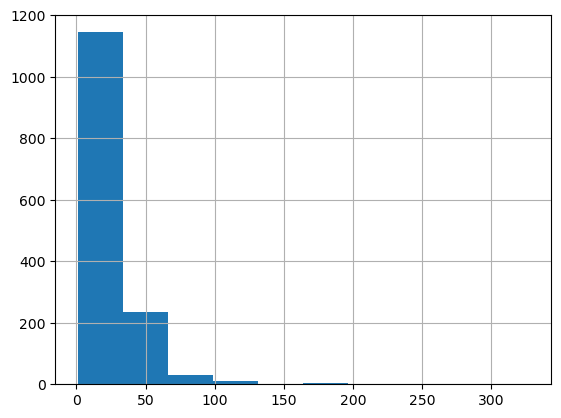

In [41]:
# Построим гистограмму пользователей прошедших курс и количества потраченных на курс дней
users_data[users_data.passed_course].day.hist()

In [42]:
# Найдем для каждокого пользователя время его первого действия
user_min_time = (
    events_df.groupby("user_id", as_index=False)
    .agg({"timestamp": "min"})
    .rename({"timestamp": "min_timestamp"}, axis=1)
)
users_data = users_data.merge(user_min_time, how="outer")
users_data.head()

,user_id,last_visit,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [43]:
# Теперь отберем некоторые наблюдения, которые удовлетворяют определенному условию
events_df_train = pd.DataFrame()

In [44]:
# Скомбинируем user_id и timestamp, чтобы упростить задачу отбора данных
events_df["user_time"] = events_df.user_id.map(str) + "_" + events_df.timestamp.map(str)
events_df.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [45]:
# В качестве минимального порога наблюдения возьмем 3 дня: 3 * 24 * 60 * 60
time_threshold = 3 * 24 * 60 * 60

# Определим дату отсечки для каждого пользователя
user_time_threshold = user_min_time.user_id.map(str) + "_" + (user_min_time.min_timestamp + time_threshold).map(str)

# Таким образом, для каждого пользователя мы отобрали только те события,
# которые вписываются во временной промежуток от начала его обучения, до трёх дней этого момента
user_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [46]:
# Добавим наши данные в основной датафрейм
user_min_time["user_time_threshold"] = user_time_threshold
events_df = events_df.merge(user_min_time[["user_id", "user_time_threshold"]], how="outer")
events_df.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [47]:
# Теперь отберем все данные, которые вписывыются а заданный диапазон времени - 3 дня
# Для этого сравним все события по времени с порогом специфичным для определенного пользователя
events_df_train = events_df[events_df.user_time <= events_df.user_time_threshold]
events_df_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [48]:
# Задание
# Используя данные о сабмитах, для каждого пользователя найдите такой шаг,
# который он не смог решить, и после этого не пытался решать другие шаги.
# Затем найдите id шага, который стал финальной точкой практического обучения на курсе для максимального числа пользователей.
# То есть мы исследуем следующий сценарий:
# человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам.
# Что это за шаг такой, который отпугнул максимальное число пользователей?

In [49]:
# Решение такое, что step_id с максимальным кол-вом неверных ответов и есть последний для тех кто бросил курс.

# Выбираем только неверные ответы, группируем их по step_id и считаем частоту для каждого step_id
wrong_answers = submissions_df[submissions_df["submission_status"] == "wrong"]
wrong_counts = wrong_answers["step_id"].value_counts()

# Получаем step_id с максимальной частотой
max_wrong_step_id = wrong_counts.idxmax()
max_wrong_step_id

31978

In [50]:
# Теперь проделаем то же самое с данными submissions
submissions_df["users_time"] = submissions_df.user_id.map(str) + "_" + submissions_df.timestamp.map(str)
submissions_df = submissions_df.merge(user_min_time[["user_id", "user_time_threshold"]], how="outer")
submissions_df_train = submissions_df[submissions_df.users_time <= submissions_df.user_time_threshold]
submissions_df_train.head()

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177


In [51]:
# Соберем в новом датафрейме свойства юзера, котоыре мы получаем за первые 3 дня его обучения
X = submissions_df_train.groupby("user_id").day.nunique().to_frame().reset_index().rename(columns={"day": "days"})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [52]:
# Посчитаем сколько каждый юзер решил степов за первые 3 дня
steps_tried = (
    submissions_df_train.groupby("user_id")
    .step_id.nunique()
    .to_frame()
    .reset_index()
    .rename(columns={"step_id": "steps_tried"})
)

# Добавим полученные значения в датасет для обучения:
X = X.merge(steps_tried, on="user_id", how="outer")
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [53]:
# Добавим количество правильных и неправильных попыток, а также их соотношение
X = X.merge(
    submissions_df_train.pivot_table(
        index="user_id",
        columns="submission_status",
        values="step_id",
        aggfunc="count",
        fill_value=0,
    ).reset_index()
)

X["correct_ratio"] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [54]:
# Добавим количество просмотренных степов
X = X.merge(
    events_df_train.pivot_table(
        index="user_id",
        columns="action",
        values="step_id",
        aggfunc="count",
        fill_value=0,
    ).reset_index()[["user_id", "viewed"]],
    how="outer",
)

X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [55]:
# Временно расшириим датафрейм X значениями пользователей: закончил или бросил пользователь курс
X = X.merge(users_data[["user_id", "passed", "is_gone"]], how="outer")
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,9,True
1,3,1.0,4.0,4.0,4.0,0.50,20,87,True
2,8,1.0,11.0,9.0,21.0,0.30,154,84,True
3,14,1.0,1.0,0.0,1.0,0.00,9,3,True
4,16,3.0,23.0,23.0,27.0,0.46,132,196,True


In [56]:
# Теперь отбросим тех пользователей, про которых мы ещё не можем сказать, ушел он или нет
X = X[X.is_gone | X.passed]

In [57]:
# Теперь определим целевую переменную
y = X.passed.map(int)
y.head()

0      9
1     87
2     84
3      3
4    196
Name: passed, dtype: int64

In [58]:
# Перенесем user_id в индекс
X.set_index(X.user_id)

# Дропнем лишние данные и заполним отсутствующие нулями для степов, которые не пытались решить
X = X.drop(["user_id", "passed", "is_gone"], axis=1)
X = X.fillna(0)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
0,1.0,2.0,2.0,0.0,1.00,9
1,1.0,4.0,4.0,4.0,0.50,20
2,1.0,11.0,9.0,21.0,0.30,154
3,1.0,1.0,0.0,1.0,0.00,9
4,3.0,23.0,23.0,27.0,0.46,132


In [59]:
# Теперь с полученными данными мы можем обучить систему и проверить,
# можем ли мы по этим данным предсказать успешность прохождения курса

In [62]:
# Обучим модель на линейной регрессии
reg_clf = LogisticRegressionCV(cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
reg_clf.fit(X_train, y_train)

/Users/narek/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [63]:
# reg_clf.score(X_test, y_test), reg_clf.coef_, reg_clf.intercept_

In [64]:
# cross_val_score(lin_clf, X_train, y_train, cv=4).mean()

In [ ]:
# Обучим модель на дереве решений с GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(criterion="entropy")
parameters = {
    "max_depth": range(3, 6),
    "max_leaf_nodes": range(6, 15),
    "min_samples_leaf": range(1, 4),
    "min_samples_split": range(2, 5),
}

tree_clf = GridSearchCV(dt, parameters, cv=4)
tree_clf.fit(X_train, y_train)

In [ ]:
model = tree_clf.best_estimator_
tree_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean()

In [ ]:
# Обучим модель на KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(15, 25), "leaf_size": range(1, 7)}
knn_clf = GridSearchCV(knn, parameters, cv=4, n_jobs=-1)
knn_clf.fit(X_train, y_train)

In [ ]:
model = knn_clf.best_estimator_
knn_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean()